In [1]:
import sys                       
sys.path.append('../scripts/')
from ideal_robot import *
from scipy.stats import uniform, norm

In [2]:
class Robot(IdealRobot):
        
    def __init__(self, pose, agent=None, sensor=None, color="black",
                           noise_prob=0.1, noise_stderr=math.pi/60, bias_rates=(0.1,0.1),
                           stuck_prob = 0.0, stuck_escape_prob = 1.0,
                           kidnap_prob = 0.0, kidnap_range_x = (-5.0,5.0), kidnap_range_y = (-5.0,5.0)):
        super().__init__(pose, agent, sensor, color)
        self.noise_prob = noise_prob
        self.noise_stderr = noise_stderr
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rates[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rates[1]) 
        
        self.stuck_prob = stuck_prob
        self.stuck_escape_prob = stuck_escape_prob
        self.is_stuck = False
        
        self.kidnap_prob = kidnap_prob
        rx, ry = kidnap_range_x, kidnap_range_y
        self.kidnap_dist = uniform(loc=(rx[0], ry[0], 0.0), scale=(rx[1]-rx[0], ry[1]-ry[0], 2*math.pi ))
        
    def noise(self):
        t_noise = 0.0
        
        if uniform.rvs() < self.noise_prob:   
            t_noise = norm.rvs(scale=self.noise_stderr) 

        return np.array([0.0, 0.0, t_noise])
        
    def bias(self, nu, omega): 
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def stuck(self, nu, omega):
        if self.is_stuck:
            self.is_stuck = uniform.rvs() >= self.stuck_escape_prob
        else:
            self.is_stuck = uniform.rvs() < self.stuck_prob

        return nu*(not self.is_stuck), omega*(not self.is_stuck)
    
    def kidnap(self, pose):
        if uniform.rvs() < self.kidnap_prob: 
            return self.kidnap_dist.rvs()
        else:
            return pose
            
    def one_step(self, time_interval):
        if not self.agent: return
        nu, omega = self.agent.decision()
        nu, omega = self.bias(nu, omega)
        nu, omega = self.stuck(nu, omega)
        self.pose = self.func_state_transition(nu, omega, time_interval, self.pose) + self.noise()
        self.pose = self.kidnap(self.pose) 
        if self.sensor: self.sensor.data(self.pose)

In [3]:
class Camera(IdealCamera): ###camera_fifth### 
    def __init__(self, env_map,
                 distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3),
                 distance_noise_rate=0.1, direction_noise=math.pi/90,
                 distance_bias_rate_stddev=0.1, direction_bias_stddev=math.pi/90,
                 phantom_prob=0.0, phantom_range_x=(-5.0,5.0), phantom_range_y=(-5.0,5.0),
                 oversight_prob=0.1): #追加
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise  
        self.distance_bias_rate = norm.rvs(scale=distance_bias_rate_stddev)
        self.direction_bias = norm.rvs(scale=direction_bias_stddev) 
        
        rx, ry = phantom_range_x, phantom_range_y
        self.phantom_dist = uniform(loc=(rx[0], ry[0]), scale=(rx[1]-rx[0], ry[1]-ry[0]))
        self.phantom_prob = phantom_prob
        
        self.oversight_prob = oversight_prob #追加
        
    def noise(self, relpos):  
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def bias(self, relpos): 
        return relpos + np.array([relpos[0]*self.distance_bias_rate,
                                  self.direction_bias]).T
    
    def phantom(self, cam_pose, relpos):
        if uniform.rvs() < self.phantom_prob:
            pos = np.array(self.phantom_dist.rvs()).T
            return self.relative_polar_pos(cam_pose, pos)
        else:
            return relpos
        
    def oversight(self, relpos): #追加
        if uniform.rvs() < self.oversight_prob:
            return None
        else:
            return relpos
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.relative_polar_pos(cam_pose, lm.pos)
            z = self.phantom(cam_pose, z) 
            z = self.oversight(z)             #追加
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)  
                observed.append((z, lm.id))
            
        self.lastdata = observed 
        return observed

<IPython.core.display.Javascript object>


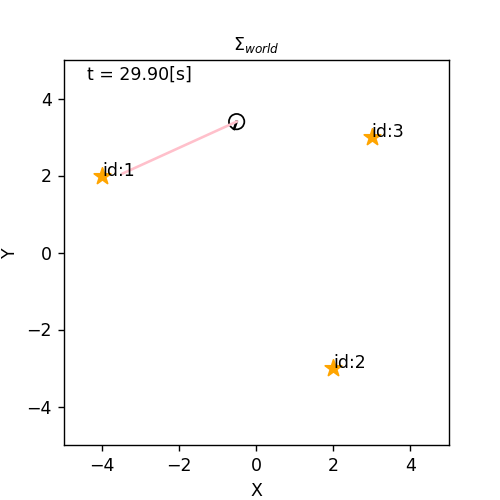

In [4]:
if __name__ == '__main__': 
    world = World(30, 0.1)  

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    straight = Agent(0.2, 0.0)    
    circling = Agent(0.2, 10.0/180*math.pi)  
    r = Robot( np.array([ 2, 2, math.pi/6]).T, sensor=Camera(m, oversight_prob=0.1), agent=circling) 
    world.append(r)

    ### アニメーション実行 ###
    world.draw()